In [1]:
!pip install -U -q segmentation-models --user

from PIL import Image
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ["SM_FRAMEWORK"] = "tf.keras"

import segmentation_models as sm
import matplotlib.pyplot as plt 
import tensorflow_io as tfio
import tensorflow as tf


root = '../input/retinal-vessel-segmentation'
exts = ('jpg', 'JPG', 'png', 'PNG', 'tif', 'gif', 'ppm')


Segmentation Models: using `tf.keras` framework.


# DRIVE

The dataset comes with pair of input retina image and target mask. Among all retina image, we will only use this dataset for a quick baseline. However, rest of the dataset can be replaces easily on this pipeline.


In [2]:
input_data = os.path.join(root, 'DRIVE/training/images')
images = sorted(
    [
        os.path.join(input_data, fname)
        for fname in os.listdir(input_data)
        if fname.endswith(exts) and not fname.startswith(".")
    ]
)


target_data = os.path.join(root, 'DRIVE/training/1st_manual')
masks = sorted(
    [
        os.path.join(target_data, fname)
        for fname in os.listdir(target_data)
        if fname.endswith(exts) and not fname.startswith(".")
    ]
)

print("Number of samples:", len(images), len(masks))
for input_path, target_path in zip(images[:10], masks[:10]):
    print(input_path[-31:], "|", target_path[-34:])

Number of samples: 20 20

training/images/21_training.tif | training/1st_manual/21_manual1.gif

training/images/22_training.tif | training/1st_manual/22_manual1.gif

training/images/23_training.tif | training/1st_manual/23_manual1.gif

training/images/24_training.tif | training/1st_manual/24_manual1.gif

training/images/25_training.tif | training/1st_manual/25_manual1.gif

training/images/26_training.tif | training/1st_manual/26_manual1.gif

training/images/27_training.tif | training/1st_manual/27_manual1.gif

training/images/28_training.tif | training/1st_manual/28_manual1.gif

training/images/29_training.tif | training/1st_manual/29_manual1.gif

training/images/30_training.tif | training/1st_manual/30_manual1.gif


In [3]:
IMAGE_SIZE = 512
BATCH_SIZE = 12

def read_files(image_path, mask=False):
    image = tf.io.read_file(image_path)
    if mask:
        image = tf.io.decode_gif(image) # out: (1, h, w, 3)
        image = tf.squeeze(image) # out: (h, w, 3)
        image = tf.image.rgb_to_grayscale(image) # out: (h, w, 1)
        image = tf.divide(image, 128)
        image.set_shape([None, None, 1])
        image = tf.image.resize(images=image, size=[IMAGE_SIZE, IMAGE_SIZE])
        image = tf.cast(image, tf.int32)
    else:
        image = tfio.experimental.image.decode_tiff(image) # out: (h, w, 4)
        image = image[:,:,:3] # out: (h, w, 3)
        image.set_shape([None, None, 3])
        image = tf.image.resize(images=image, size=[IMAGE_SIZE, IMAGE_SIZE])
        image = image / 255.
    return image

def load_data(image_list, mask_list):
    image = read_files(image_list)
    mask  = read_files(mask_list, mask=True)
    return image, mask

def data_generator(image_list, mask_list):
    dataset = tf.data.Dataset.from_tensor_slices((image_list, mask_list))
    dataset = dataset.map(load_data, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(BATCH_SIZE, drop_remainder=False)
    return dataset

train_dataset = data_generator(images, masks)
train_dataset

<BatchDataset shapes: ((None, 512, 512, 3), (None, 512, 512, 1)), types: (tf.float32, tf.int32)>

In [4]:
def visualize(**images):
    """PLot images in one row."""
    n = len(images) 
    plt.figure(figsize=(20, 20))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image, cmap='gray')
    plt.show()

(12, 512, 512, 3) (12, 512, 512, 1)

0 1

[0 1]


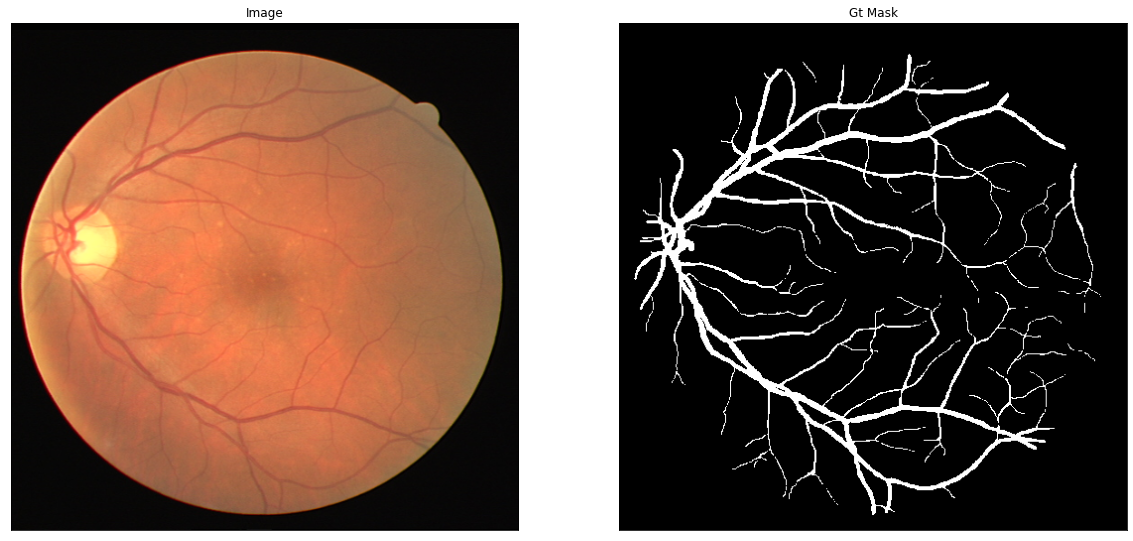

0 1

[0 1]


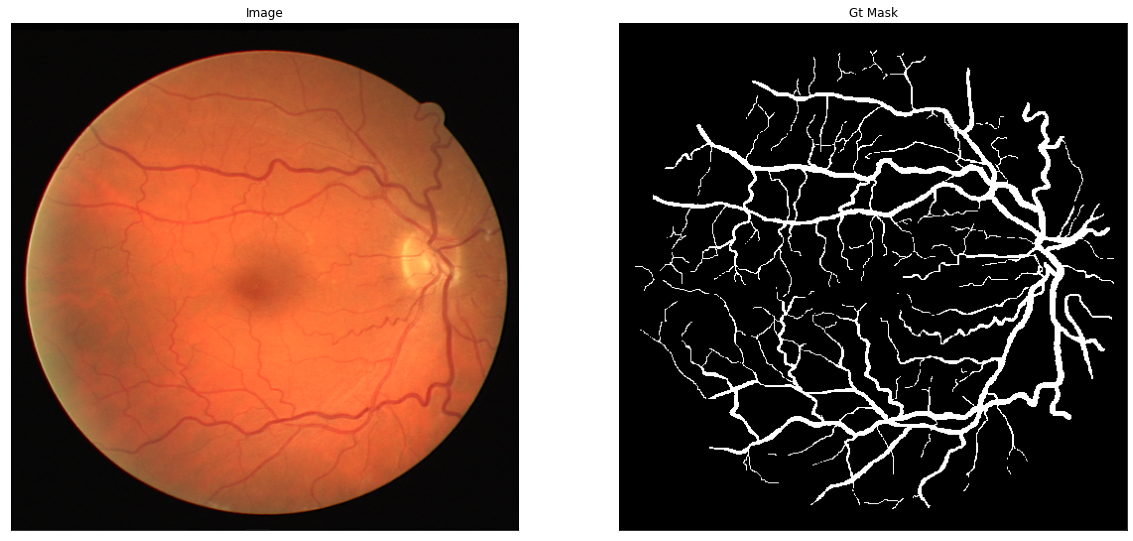

0 1

[0 1]


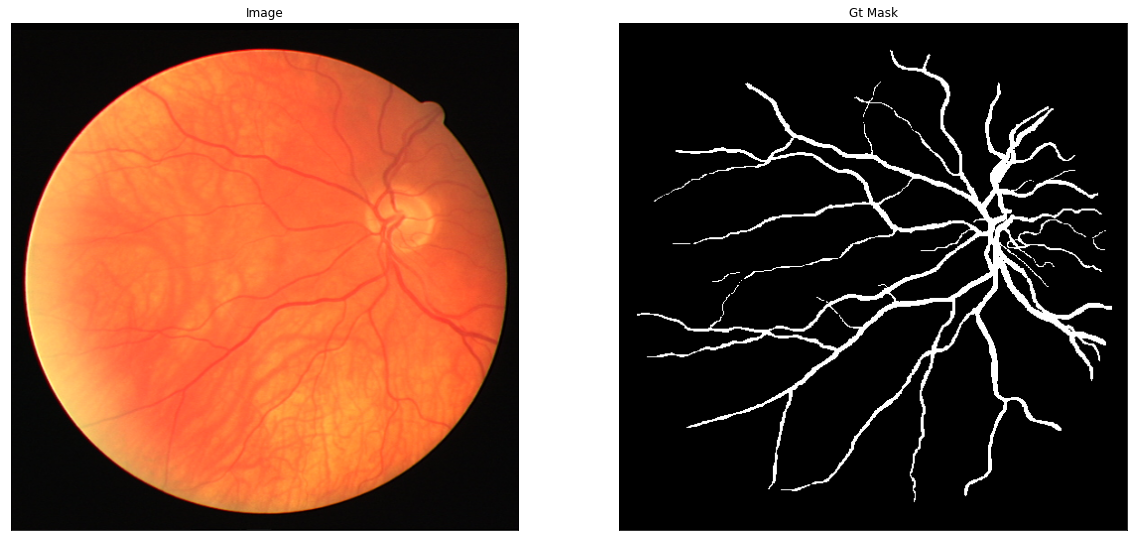

0 1

[0 1]


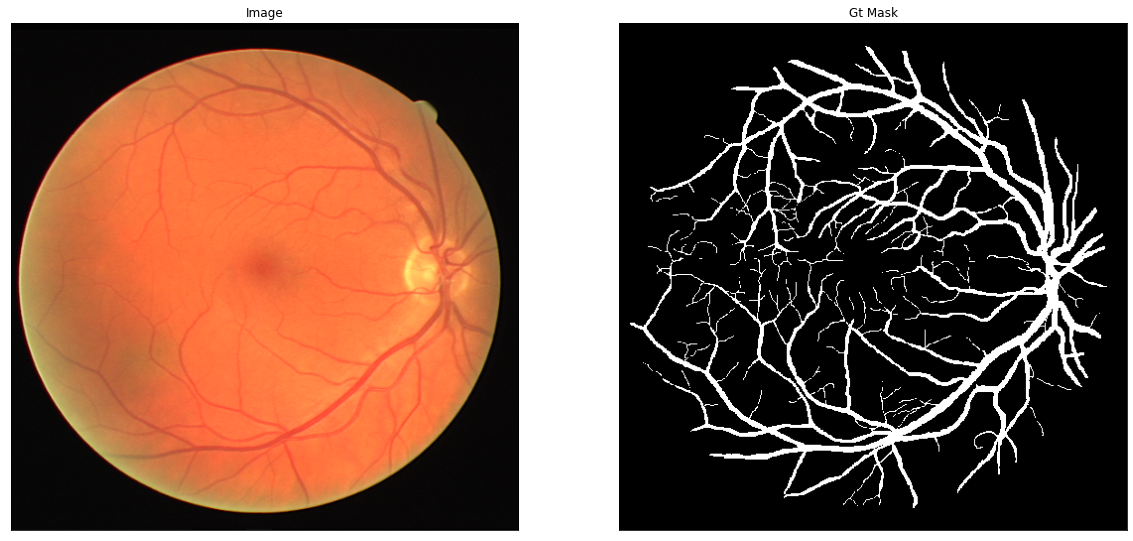

0 1

[0 1]


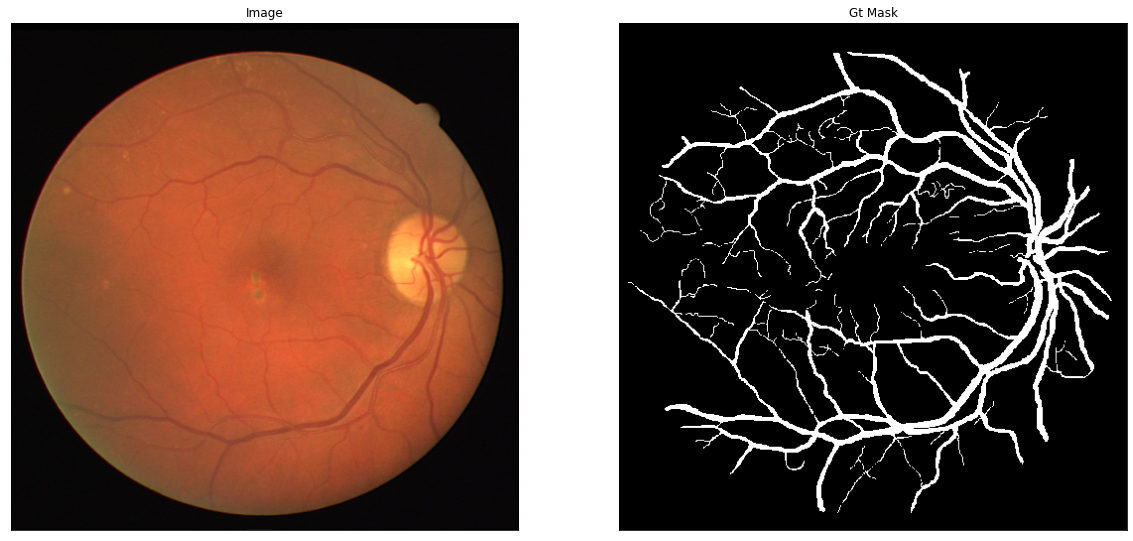

In [5]:
image, mask = next(iter(train_dataset.take(1))) 
print(image.shape, mask.shape)

for (img, msk) in zip(image[:5], mask[:5]):
    print(mask.numpy().min(), mask.numpy().max())
    print(np.unique(mask.numpy()))
    visualize(
        image=img.numpy(),
        gt_mask=msk.numpy(),
    )

# Build and train our neural network


![](https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/u-net-architecture.png)

# Build U-Net model
inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
s = Lambda(lambda x: x / 255) (inputs)
s = inputs
c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (s)
c1 = Dropout(0.1) (c1)
c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c1)
p1 = MaxPooling2D((2, 2)) (c1)

c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p1)
c2 = Dropout(0.1) (c2)
c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c2)
p2 = MaxPooling2D((2, 2)) (c2)

c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p2)
c3 = Dropout(0.2) (c3)
c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c3)
p3 = MaxPooling2D((2, 2)) (c3)

c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p3)
c4 = Dropout(0.2) (c4)
c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c4)
p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p4)
c5 = Dropout(0.3) (c5)
c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c5)

u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (c5)
u6 = concatenate([u6, c4])
c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u6)
c6 = Dropout(0.2) (c6)
c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c6)

u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c6)
u7 = concatenate([u7, c3])
c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u7)
c7 = Dropout(0.2) (c7)
c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c7)

u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c7)
u8 = concatenate([u8, c2])
c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u8)
c8 = Dropout(0.1) (c8)
c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c8)

u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c8)
u9 = concatenate([u9, c1], axis=3)
c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u9)
c9 = Dropout(0.1) (c9)
c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c9)

outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)

model = Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[mean_iou])
model.summary()

In [6]:
from tensorflow import keras 

# Free up RAM in case the model definition cells were run multiple times
keras.backend.clear_session()
BACKBONE   = 'efficientnetb0'
n_classes  = 1 
activation = 'sigmoid' 
model = sm.Unet(BACKBONE, classes=n_classes, activation=activation)
# model.summary(line_length=110)


16809984/16804768 [==============================] - 1s 0us/step

16818176/16804768 [==============================] - 1s 0us/step


# Callback : Monitoring Training Progress

In [7]:
class DisplayCallback(keras.callbacks.Callback):
    def __init__(self, dataset, epoch_interval=50):
        self.dataset = dataset
        self.epoch_interval = epoch_interval
    
    def display(self, display_list, extra_title=''):
        plt.figure(figsize=(15, 15))
        title = ['Input Image', 'True Mask', 'Predicted Mask']

        if len(display_list) > len(title):
            title.append(extra_title)

        for i in range(len(display_list)):
            plt.subplot(1, len(display_list), i+1)
            plt.title(title[i])
            plt.imshow(display_list[i], cmap='gray')
            plt.axis('off')
        plt.show()
        
    def create_mask(self, pred_mask):
        pred_mask = (pred_mask > 0.5).astype("int32")
        return pred_mask[0]
    
    def show_predictions(self, dataset, num=1):
        for image, mask in dataset.take(num):
            pred_mask = model.predict(image)
            self.display([image[0], mask[0], self.create_mask(pred_mask)])
        
    def on_epoch_end(self, epoch, logs=None):
        if epoch and epoch % self.epoch_interval == 0:
            self.show_predictions(self.dataset)
            print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

# Compile and Fit

Epoch 1/400

2/2 [==============================] - 20s 3s/step - loss: 0.7741 - accuracy: 0.4358

Epoch 2/400

2/2 [==============================] - 1s 419ms/step - loss: 0.7396 - accuracy: 0.4983

Epoch 3/400

2/2 [==============================] - 1s 426ms/step - loss: 0.7139 - accuracy: 0.5406

Epoch 4/400

2/2 [==============================] - 1s 423ms/step - loss: 0.6920 - accuracy: 0.5689

Epoch 5/400

2/2 [==============================] - 1s 418ms/step - loss: 0.6706 - accuracy: 0.5915

Epoch 6/400

2/2 [==============================] - 1s 420ms/step - loss: 0.6515 - accuracy: 0.6124

Epoch 7/400

2/2 [==============================] - 1s 419ms/step - loss: 0.6342 - accuracy: 0.6337

Epoch 8/400

2/2 [==============================] - 1s 420ms/step - loss: 0.6184 - accuracy: 0.6568

Epoch 9/400

2/2 [==============================] - 1s 418ms/step - loss: 0.6037 - accuracy: 0.6800

Epoch 10/400

2/2 [==============================] - 1s 418ms/step - loss: 0.5900 - accuracy:

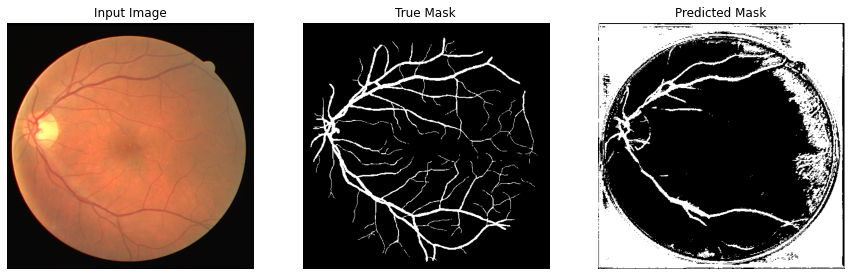



Sample Prediction after epoch 51



Epoch 52/400

2/2 [==============================] - 1s 426ms/step - loss: 0.3079 - accuracy: 0.9503

Epoch 53/400

2/2 [==============================] - 1s 418ms/step - loss: 0.3033 - accuracy: 0.9521

Epoch 54/400

2/2 [==============================] - 1s 418ms/step - loss: 0.2996 - accuracy: 0.9531

Epoch 55/400

2/2 [==============================] - 1s 417ms/step - loss: 0.2960 - accuracy: 0.9541

Epoch 56/400

2/2 [==============================] - 1s 420ms/step - loss: 0.2924 - accuracy: 0.9551

Epoch 57/400

2/2 [==============================] - 1s 419ms/step - loss: 0.2890 - accuracy: 0.9559

Epoch 58/400

2/2 [==============================] - 1s 419ms/step - loss: 0.2857 - accuracy: 0.9568

Epoch 59/400

2/2 [==============================] - 1s 420ms/step - loss: 0.2835 - accuracy: 0.9571

Epoch 60/400

2/2 [==============================] - 1s 417ms/step - loss: 0.2804 - accuracy: 0.9584

Epoch 61/400

2/2 [=========================

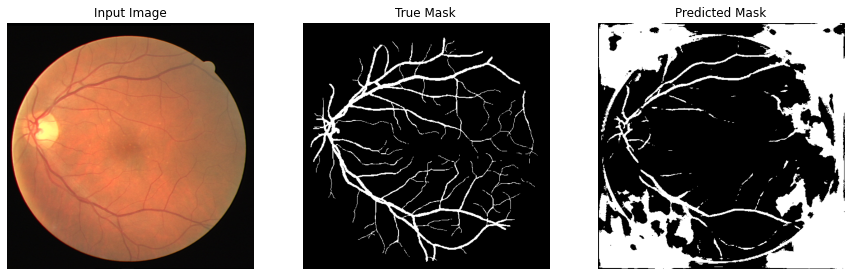



Sample Prediction after epoch 101



Epoch 102/400

2/2 [==============================] - 1s 405ms/step - loss: 0.2061 - accuracy: 0.9695

Epoch 103/400

2/2 [==============================] - 1s 419ms/step - loss: 0.2044 - accuracy: 0.9701

Epoch 104/400

2/2 [==============================] - 1s 419ms/step - loss: 0.2038 - accuracy: 0.9699

Epoch 105/400

2/2 [==============================] - 1s 421ms/step - loss: 0.2020 - accuracy: 0.9702

Epoch 106/400

2/2 [==============================] - 1s 421ms/step - loss: 0.2005 - accuracy: 0.9705

Epoch 107/400

2/2 [==============================] - 1s 407ms/step - loss: 0.1997 - accuracy: 0.9706

Epoch 108/400

2/2 [==============================] - 1s 418ms/step - loss: 0.1983 - accuracy: 0.9708

Epoch 109/400

2/2 [==============================] - 1s 418ms/step - loss: 0.1978 - accuracy: 0.9705

Epoch 110/400

2/2 [==============================] - 1s 419ms/step - loss: 0.1964 - accuracy: 0.9708

Epoch 111/400

2/2 [==============

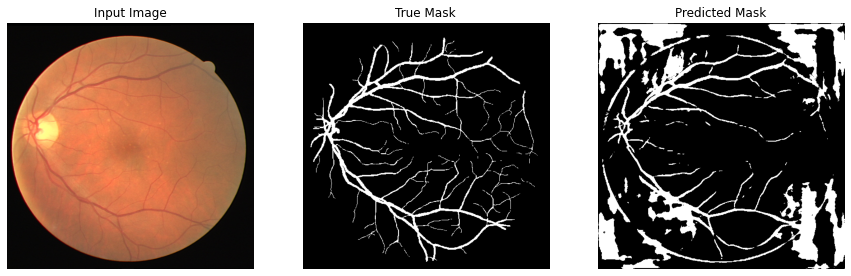



Sample Prediction after epoch 151



Epoch 152/400

2/2 [==============================] - 1s 418ms/step - loss: 0.1551 - accuracy: 0.9765

Epoch 153/400

2/2 [==============================] - 1s 420ms/step - loss: 0.1552 - accuracy: 0.9759

Epoch 154/400

2/2 [==============================] - 1s 417ms/step - loss: 0.1548 - accuracy: 0.9757

Epoch 155/400

2/2 [==============================] - 1s 420ms/step - loss: 0.1532 - accuracy: 0.9764

Epoch 156/400

2/2 [==============================] - 1s 419ms/step - loss: 0.1526 - accuracy: 0.9765

Epoch 157/400

2/2 [==============================] - 1s 420ms/step - loss: 0.1520 - accuracy: 0.9764

Epoch 158/400

2/2 [==============================] - 1s 418ms/step - loss: 0.1508 - accuracy: 0.9769

Epoch 159/400

2/2 [==============================] - 1s 407ms/step - loss: 0.1504 - accuracy: 0.9767

Epoch 160/400

2/2 [==============================] - 1s 420ms/step - loss: 0.1504 - accuracy: 0.9763

Epoch 161/400

2/2 [==============

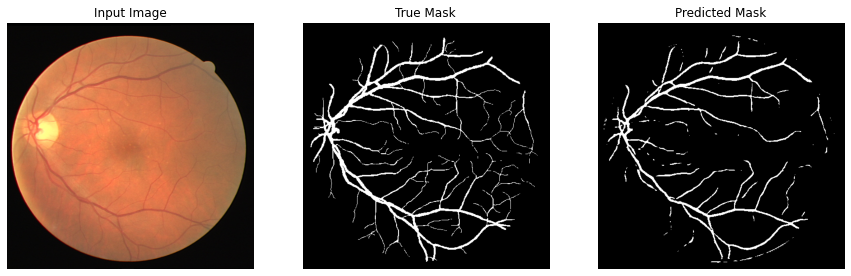



Sample Prediction after epoch 201



Epoch 202/400

2/2 [==============================] - 1s 416ms/step - loss: 0.1227 - accuracy: 0.9805

Epoch 203/400

2/2 [==============================] - 1s 419ms/step - loss: 0.1225 - accuracy: 0.9803

Epoch 204/400

2/2 [==============================] - 1s 418ms/step - loss: 0.1212 - accuracy: 0.9809

Epoch 205/400

2/2 [==============================] - 1s 419ms/step - loss: 0.1204 - accuracy: 0.9812

Epoch 206/400

2/2 [==============================] - 1s 417ms/step - loss: 0.1200 - accuracy: 0.9810

Epoch 207/400

2/2 [==============================] - 1s 418ms/step - loss: 0.1201 - accuracy: 0.9808

Epoch 208/400

2/2 [==============================] - 1s 412ms/step - loss: 0.1190 - accuracy: 0.9812

Epoch 209/400

2/2 [==============================] - 1s 418ms/step - loss: 0.1192 - accuracy: 0.9808

Epoch 210/400

2/2 [==============================] - 1s 419ms/step - loss: 0.1183 - accuracy: 0.9811

Epoch 211/400

2/2 [==============

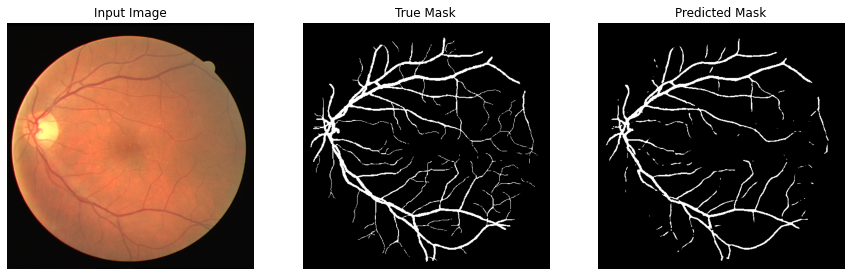



Sample Prediction after epoch 251



Epoch 252/400

2/2 [==============================] - 1s 420ms/step - loss: 0.0993 - accuracy: 0.9835

Epoch 253/400

2/2 [==============================] - 1s 417ms/step - loss: 0.0984 - accuracy: 0.9839

Epoch 254/400

2/2 [==============================] - 1s 419ms/step - loss: 0.0982 - accuracy: 0.9838

Epoch 255/400

2/2 [==============================] - 1s 419ms/step - loss: 0.0973 - accuracy: 0.9842

Epoch 256/400

2/2 [==============================] - 1s 421ms/step - loss: 0.0973 - accuracy: 0.9840

Epoch 257/400

2/2 [==============================] - 1s 418ms/step - loss: 0.0971 - accuracy: 0.9838

Epoch 258/400

2/2 [==============================] - 1s 418ms/step - loss: 0.0972 - accuracy: 0.9837

Epoch 259/400

2/2 [==============================] - 1s 419ms/step - loss: 0.0962 - accuracy: 0.9841

Epoch 260/400

2/2 [==============================] - 1s 417ms/step - loss: 0.0966 - accuracy: 0.9836

Epoch 261/400

2/2 [==============

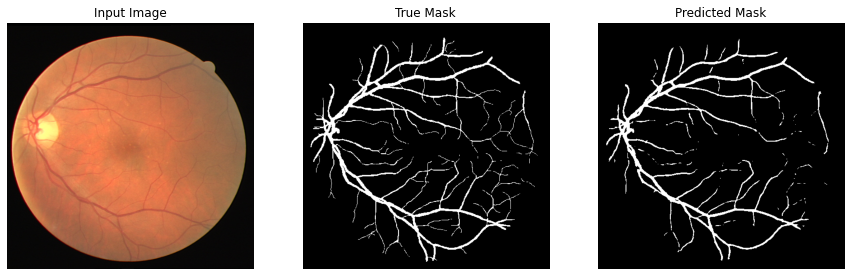



Sample Prediction after epoch 301



Epoch 302/400

2/2 [==============================] - 1s 418ms/step - loss: 0.0816 - accuracy: 0.9861

Epoch 303/400

2/2 [==============================] - 1s 424ms/step - loss: 0.0817 - accuracy: 0.9858

Epoch 304/400

2/2 [==============================] - 1s 418ms/step - loss: 0.0808 - accuracy: 0.9864

Epoch 305/400

2/2 [==============================] - 1s 417ms/step - loss: 0.0803 - accuracy: 0.9865

Epoch 306/400

2/2 [==============================] - 1s 417ms/step - loss: 0.0803 - accuracy: 0.9863

Epoch 307/400

2/2 [==============================] - 1s 404ms/step - loss: 0.0796 - accuracy: 0.9868

Epoch 308/400

2/2 [==============================] - 1s 418ms/step - loss: 0.0794 - accuracy: 0.9867

Epoch 309/400

2/2 [==============================] - 1s 418ms/step - loss: 0.0799 - accuracy: 0.9863

Epoch 310/400

2/2 [==============================] - 1s 418ms/step - loss: 0.0794 - accuracy: 0.9865

Epoch 311/400

2/2 [==============

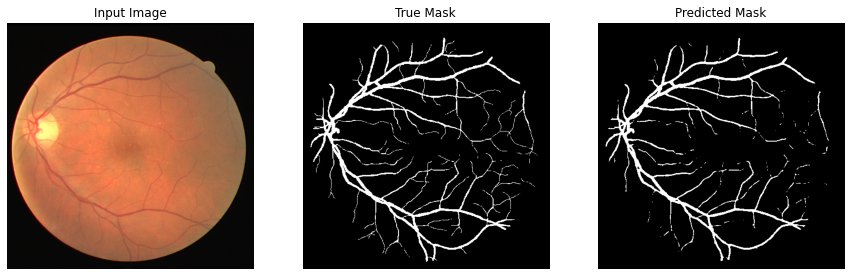



Sample Prediction after epoch 351



Epoch 352/400

2/2 [==============================] - 1s 418ms/step - loss: 0.0680 - accuracy: 0.9887

Epoch 353/400

2/2 [==============================] - 1s 420ms/step - loss: 0.0684 - accuracy: 0.9882

Epoch 354/400

2/2 [==============================] - 1s 417ms/step - loss: 0.0683 - accuracy: 0.9880

Epoch 355/400

2/2 [==============================] - 1s 418ms/step - loss: 0.0682 - accuracy: 0.9880

Epoch 356/400

2/2 [==============================] - 1s 418ms/step - loss: 0.0682 - accuracy: 0.9879

Epoch 357/400

2/2 [==============================] - 1s 417ms/step - loss: 0.0682 - accuracy: 0.9878

Epoch 358/400

2/2 [==============================] - 1s 422ms/step - loss: 0.0677 - accuracy: 0.9880

Epoch 359/400

2/2 [==============================] - 1s 420ms/step - loss: 0.0674 - accuracy: 0.9881

Epoch 360/400

2/2 [==============================] - 1s 418ms/step - loss: 0.0665 - accuracy: 0.9887

Epoch 361/400

2/2 [==============

In [8]:
# define optomizer
optim = keras.optimizers.Adam(0.0001)
bce   = keras.losses.BinaryCrossentropy()
metrics = ["accuracy"]

# compile keras model with defined optimozer, loss and metrics
model.compile(optim, bce, metrics)

model.fit(
    train_dataset, 
    callbacks=[DisplayCallback(train_dataset)],
    epochs=400
)

In [9]:
model.save('seg.h5')
# model.save_weights('./seg.h5')

/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.

  category=CustomMaskWarning)
